In [4]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, parent_dir) 

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from Evaluation import get_metrics
import time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Read Data

In [6]:
from Data_prep import leave_last_out

In [7]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '../'

In [27]:
data_path = 'Data/Amazon/'
file_name = 'am_20k_users'
# file_name = 'am_like_ml'

# data_path = 'Data/ML/'
# file_name = 'ml_1m'

In [28]:
df = pd.read_pickle(path + data_path + file_name)
total_items = df.item_id.nunique()
total_users = df.user_id.nunique()

In [29]:
# CFRNN Data
train_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_train_cfrnn')
val_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_val_cfrnn')
test_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_test_cfrnn')

# MF based Data
train_set_mf = pd.read_pickle(path + data_path + file_name + '_train_mf')
val_set_mf = pd.read_pickle(path + data_path + file_name + '_val_mf')
test_set_mf = pd.read_pickle(path + data_path + file_name + '_test_mf')

In [30]:
# Eval
steps = 5
rank_at = 20

---
## Set Parameters

In [31]:
bpr_params = {
"nolf": 8, #Size of latent feature vectors
"n_iterations": 25, #around 20 is sufficient
"sample_size": 0.3*len(train_set_mf), # number of uij samples to be observed per epoch
"seed": 1234,
"alpha": 0.03, # Learning rate: Amazon_01 best: 0.08
"rho": 1.05, # Bold driver increase alpha
"sigma": 0.55, # Bold driver decrease alpha
          
"reg_user": 0, # Am_40k best: 0.1 # ML_1 best: 0
"reg_item": 0, # Am_40k best: 0.1 # ML_1 best: 0
}

In [32]:
cfrnn_params = {
'epochs': 100,
'BATCH_SIZE': 16,
'learning_rate': 0.2,
'delta': 0.01,             # Diversity Bias
'max_seq_len': 30,        # Max length of sequence71=median
'embedding_dim': 100,
'rnn_units': 20,
'ckpt_dir':  '',#path + f'Logs/ckpts/cfrnn_ckpts_{file_name}/ckpts',

'pad_value': total_items, #total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by': 1
}

In [48]:
GMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'nolf': 8,
    'regs': [0.000001,0.000001],
    'epochs': 10,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/GMF_weights_{file_name}/GMF_weights',
    'optimizer':'Adam'
}

MLP_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0.00001,0.00001,0.00001,0.00001],   #ML: [+-0.0005,0,0,0],
    'epochs': 10,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 10,
    'weights_dir': f'../Logs/weights/MLP_weights_{file_name}/MLP_weights',
    'optimizer':'Adam'
}

NeuMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0.00001,0.00001,0.00001,0.00001],#[0.0001, 0.0001, 0.0001, 0.0001],
    'reg_mf': [0.000001,0.000001],
    'nolf': 8,
    'epochs': 3,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/NeuMF_weights_{file_name}/NeuMF_weights',
    'optimizer':'Adam'
}

---
---
---
# Train and test the algorithms

---
# BPR

In [49]:
len(train_set_mf)*0.3

299612.7

In [50]:
from BPR import BPR
bpr = BPR(total_users, total_items, bpr_params)

In [51]:
samples_name = file_name + '_bpr_samples'

In [13]:
samples = bpr.create_samples(train_set_mf)

Creating 25 samples of length 299612


KeyboardInterrupt: 

In [46]:
samples = np.array(samples)
np.save(path + data_path + 'Samples/' + samples_name, samples)

In [12]:
%%time
bpr.train_model(sample_path = path + data_path + 'Samples/' + samples_name + '_0.3.npy', 
                train_set=train_set_mf, 
                val_set=val_set_mf,
                verbose=1,
                patience=10,
                save_best=True)

Training BPR on 25 samples of size 299612
iteration: 0  loss: 0.692884  val_rec@10: 0.012
iteration: 1  loss: 0.688536  val_rec@10: 0.036
iteration: 2  loss: 0.616522  val_rec@10: 0.052


KeyboardInterrupt: 

new results created


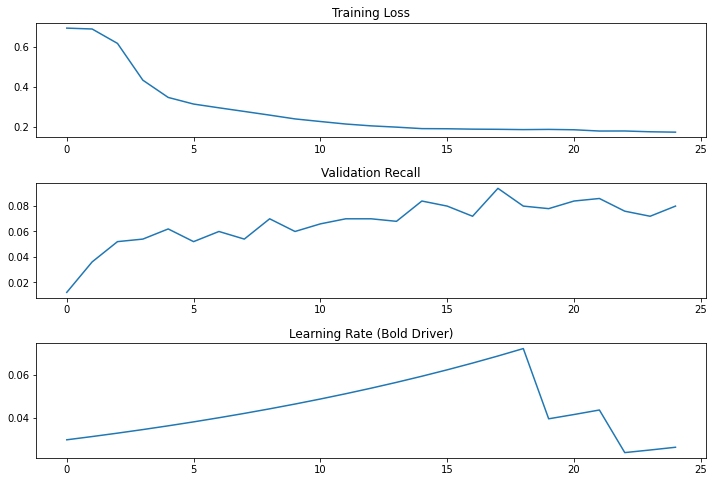

In [14]:
bpr.store_model(path + '/Logs/', file_name + '_bpr_log', file_name)
bpr.plot_training()

In [15]:
ranked_df_bpr = bpr.get_predictions(train_set_mf, test_set_mf, stats=False)
bpr_metrics = get_metrics(ranked_df_bpr, steps, rank_at, stats=False)
bpr_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,7,0.007,0.007000,0.007000
1,5,30,0.030,0.006000,0.017834
2,10,56,0.056,0.005600,0.026094
3,15,71,0.071,0.004733,0.030077
4,20,96,0.096,0.004800,0.036003


In [58]:
ranked_df_bpr = bpr.get_predictions(train_set_mf, test_set_mf, stats=False)
bpr_metrics = get_metrics(ranked_df_bpr, steps, rank_at, stats=False)
bpr_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,45,0.0225,0.022500,0.022500
1,5,66,0.0330,0.006600,0.027843
2,10,76,0.0380,0.003800,0.029455
3,15,77,0.0385,0.002567,0.029583
4,20,80,0.0400,0.002000,0.029932


In [18]:
bpr_metrics.to_pickle(path + 'Results/BPR/' + file_name + '_metrics')

---
# CFRNN

In [21]:
from CFRNN import CFRNN
cfrnn = CFRNN(total_users, total_items, cfrnn_params)
cfrnn.build_model(summary=False)
cfrnn.compile_model(train_set=train_set_cfrnn)

Creating Diveristy Bias
Compiled LSTM


In [22]:
train_dataset = cfrnn.create_seq_batch_tf_dataset(train_set_cfrnn, stats=False)
val_dataset = cfrnn.create_seq_batch_tf_dataset(val_set_cfrnn, stats=False)

#### Train

In [ ]:
s = time.time()
cfrnn.train(train_dataset, val_dataset, verbose=0)

additional_info = {'all_val_rec@10':[], 'all_val_ndcg@10':[], 'val_metrics':[]}
for e in range(1, cfrnn_params['epochs'], 1):
    ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, val_set, left_out_val, batch_size=500, rank_at=rank_at, 
                                            ckpt_dir=f'{path}Logs/final/ckpts/cfrnn_ckpts_{file_name}_run_{i}/ckpts_{e}')
    cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
    additional_info['all_val_rec@10'].append(cfrnn_metrics['recall'].iloc[2]) 
    additional_info['all_val_ndcg@10'].append(cfrnn_metrics['ndcg'].iloc[2])
    additional_info['val_metrics'].append(cfrnn_metrics)
t = time.time() - s

#### Test and Store

In [ ]:
ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, test_set, left_out_test, batch_size=500, rank_at=rank_at, 
                                            ckpt_dir=f'{path}Logs/final/ckpts/cfrnn_ckpts_{file_name}_run_{i}/ckpts_{e}')
cfrnn_test_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
additional_info['metrics'] = cfrnn_test_metrics
additional_info['train_time'] = t

store_path = path + '/Logs/final/' + file_name +  '_cfrnn_log'
cfrnn.store_model(store_path, additional_info)

In [35]:
test_set, left_out = leave_last_out(test_set_cfrnn, n_items=1)
ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, test_set, left_out, batch_size=500, rank_at=rank_at, ckpt_dir=cfrnn_params['ckpt_dir'])
cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
cfrnn_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,4,0.004,0.004000,0.004000
1,5,19,0.019,0.003800,0.011119
2,10,43,0.043,0.004300,0.018755
3,15,71,0.071,0.004733,0.026086
4,20,92,0.092,0.004600,0.031059


In [36]:
cfrnn_metrics.to_pickle(path + 'Results/CFRNN/' + file_name + '_metrics')

---
# NCF

In [49]:
from NCF import NCF
NCF = NCF(total_users, total_items, GMF_params, MLP_params, NeuMF_params)
NCF.build_GMF_model()
NCF.build_MLP_model()
NCF.build_NeuMF_model()

In [ ]:
from Helpers import create_ncf_samples
create_ncf_samples(NeuMF_params, train_set_mf, path + data_path + 'Samples', file_name)

In [57]:
sample_path = path + data_path + 'Samples/' + file_name + '_samples_4_neg/'
samples = NCF.load_samples(sample_path, file_name + '_samples_4_neg', 3)

100% |########################################################################|


In [ ]:
GMF_val_metrics = NCF.train_model('GMF', samples)

In [25]:
MLP_val_metrics = NCF.train_model('MLP', samples)


Fitting MLP with parameters:
learning_rate                                               0.0005
batch_size                                                     256
layers                                             [16, 32, 16, 8]
reg_layers                            [1e-05, 1e-05, 1e-05, 1e-05]
epochs                                                          10
sample_size                                                 176012
num_neg                                                         10
weights_dir      ../Logs/weights/MLP_weights_am_like_ml/MLP_wei...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 880060 samples


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


880060/880060 [==============================] - 17s 19us/sample - loss: 0.3631
Epoch: 1
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2922
Epoch: 2
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2802
Epoch: 3
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2617
Epoch: 4
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.2223
Epoch: 5
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1792
Epoch: 6
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1460
Epoch: 7
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1222
Epoch: 8
Train on 880060 samples
880060/880060 [==============================] - 15s 17us/sample - loss: 0.1055
Epoch: 9
Train o

In [26]:
NCF.use_pretrain_model()
NCF.NeuMF_params['optimizer'] = 'SGD'

In [ ]:
NeuMF_val_metrics = NCF.train_model('NeuMF', samples, train_set=train_set_mf, val_set=val_set_mf)

In [39]:
ranked_df_neumf = NCF.get_predictions('NeuMF', train_set=train_set_mf, test_set=test_set_mf)
neumf_metrics = get_metrics(ranked_df_neumf, stats=False)
neumf_metrics

100% |########################################################################|


,rank_at,hitcounts,recall,precision,ndcg
0,1,0,0.0000,0.00000,0.000000
1,5,1,0.0005,0.00010,0.000215
2,10,2,0.0010,0.00010,0.000360
3,15,3,0.0015,0.00010,0.000499
4,20,6,0.0030,0.00015,0.000843


In [28]:
ranked_df_neumf = NCF.get_predictions('NeuMF', train_set=train_set_mf, test_set=test_set_mf)
neumf_metrics = get_metrics(ranked_df_neumf, stats=False)
neumf_metrics

100% |########################################################################|


,rank_at,hitcounts,recall,precision,ndcg
0,1,9,0.009,0.009000,0.009000
1,5,19,0.019,0.003800,0.013959
2,10,24,0.024,0.002400,0.015539
3,15,32,0.032,0.002133,0.017668
4,20,38,0.038,0.001900,0.019069


In [29]:
neumf_metrics.to_pickle(path + 'Results/NCF/' + file_name + '_metrics')

---
## Compare

In [52]:
# file_name = 'ml_1m'
file_name = 'am_20k_users'
# file_name = 'am_like_ml'

In [53]:
bpr_metrics = pd.read_pickle(path + 'Results/BPR/' + file_name + '_metrics')
neumf_metrics = pd.read_pickle(path + 'Results/NCF/' + file_name + '_metrics')
cfrnn_metrics = pd.read_pickle(path + 'Results/CFRNN/' + file_name + '_metrics')

In [54]:
store_path = path + 'Plots/' + file_name
plot_title = f'Comparison {file_name}'

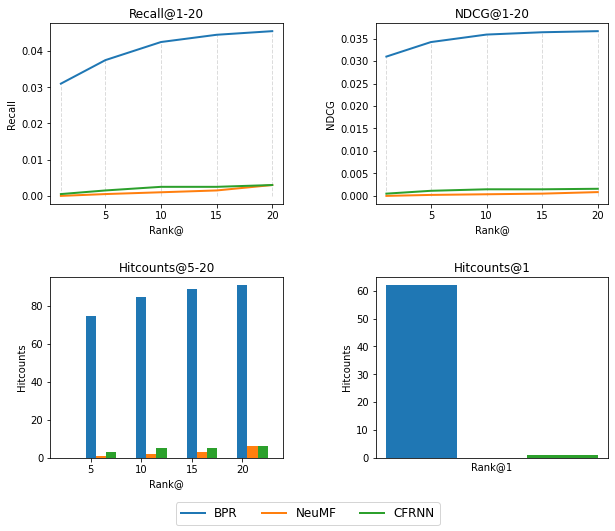

In [55]:
from visualize_results import plot_metrics
plot_metrics([bpr_metrics, neumf_metrics, cfrnn_metrics], ['BPR', 'NeuMF', 'CFRNN'], store_path=store_path)